In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df=pd.read_csv(data)
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine learning algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Machine learning pipeline 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
#checking null values
df.isnull().sum()

cycle_number                  0
ambient_temperature           0
datetime                      0
capacity                1136906
voltage_measured              2
current_measured              2
temperature_measured          2
time                          0
cell_id                       0
dtype: int64

For Filling missing values, we used average method. We used previous and next value to arrive at the average

In [4]:
#filling missing values
df['voltage_measured']=df['voltage_measured'].fillna((df['voltage_measured'].shift(1) +df['voltage_measured'].shift(-1))/2)
df['current_measured']=df['current_measured'].fillna((df['current_measured'].shift(1) +df['current_measured'].shift(-1))/2)
df['temperature_measured']=df['temperature_measured'].fillna((df['temperature_measured'].shift(1) +df['temperature_measured'].shift(-1))/2)

# Visualising data

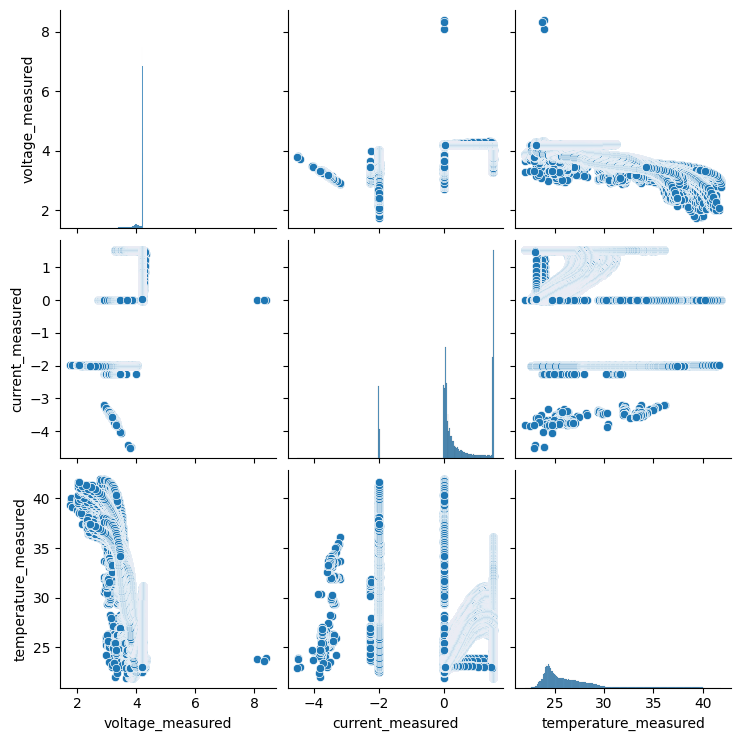

In [5]:
numerical_features=['voltage_measured','current_measured','temperature_measured']

sns.pairplot(df[numerical_features])

# Capacity calculation assumption

Capacity estimation can be done via both charging and discharging 

Since Current is constant in discharging, its advised to use discharge cycles

Same is explained in the image below
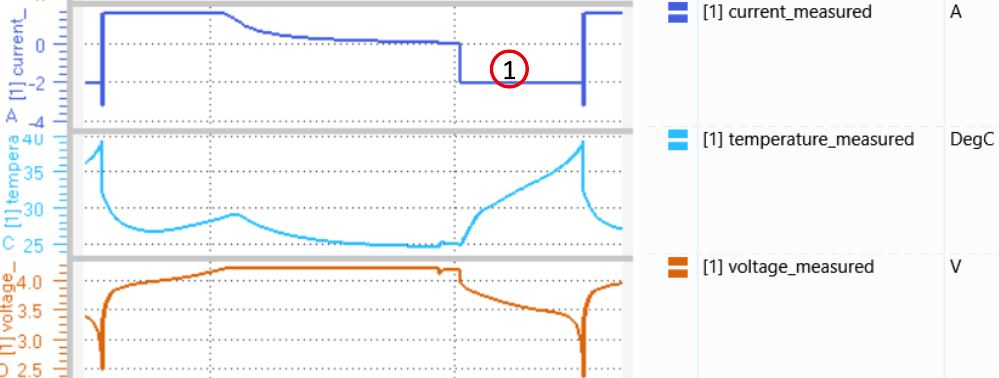


After complete discharge, relay swith on is causing the sudden spike in discharge current.
To filter the phenomeno, we have used volatge positive slope at the end of cycle

Since the current remains constant throughout, last time stamp at 100% discharge state, represents total discharge time.

Since we have used Cummulative time approach to calculate capacity. We can select only last row in each cell id, which prepresents final capacity of the cell at cycle number 'i'



# Capacity calculaton using entire series data

In [ ]:
#function to calculate capacity of each cell at each cycle
def capacity_calculation(dataframe):
    dataframe['q']=(dataframe['current_measured'] * (dataframe['time'].shift() - dataframe['time'])).cumsum()
    capacity = dataframe['q'].max() / 3600
    
    return capacity

In [6]:
#dropping nan values if any
df.dropna(inplace=True)
#filtering df if current measured is too high
df=df[df['current_measured']>-3]
#splitting charge discharge cycles based on current direction
df_discharge=df[df['current_measured']<-0.1]
#removing points with positive voltage slope during discharge
df_discharge["diff"] = df_discharge["voltage_measured"] - df_discharge["voltage_measured"].shift()
df_discharge.dropna()
df_discharge= df_discharge[df_discharge["diff"] < 0]
#getting one value for each cell and cycle
df_discharge1=df_discharge.groupby(['cell_id','cycle_number']).last().reset_index()


# Feature Engineering
creating new features based on available features

In [7]:

df_discharge1['V/t']=df_discharge1['voltage_measured']/df_discharge1['time']
df_discharge1['Vt']=df_discharge1['voltage_measured']*df_discharge1['time']
df_discharge1['VT']=df_discharge1['voltage_measured']*df_discharge1['temperature_measured']
df_discharge1['V/T']=df_discharge1['voltage_measured']/df_discharge1['temperature_measured']

<Axes: >

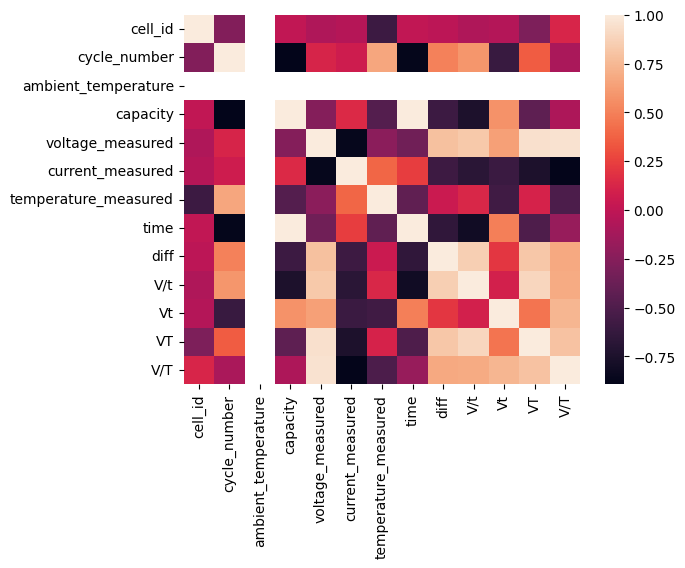

In [8]:
#Checking the correlation of newly created feature points
sns.heatmap(df_discharge1.corr())

# Choosing the model
## We will check with all available models and check the plots before finalizing 

We will chose data from one single cell, let the cell be 5 

In [9]:
df_discharge_cell_5 = df_discharge1[df_discharge1["cell_id"]==5]
df_discharge_cell_5.drop("datetime", axis=1, inplace=True)

In [10]:
df_discharge_cell_5.head()

,cell_id,cycle_number,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,time,diff,V/t,Vt,VT,V/T
0,5,1,24,1.856487,2.612467,-2.012639,38.904112,3346.937,-0.144785,0.000781,8743.763628,101.635723,0.067151
1,5,3,24,1.846327,2.587209,-2.010960,38.934590,3328.828,-0.170660,0.000777,8612.372859,100.731911,0.066450
2,5,5,24,1.835349,2.651917,-2.013052,38.743649,3309.422,-0.157885,0.000801,8776.312111,102.744938,0.068448
3,5,7,24,1.835263,2.592948,-2.010652,38.672511,3309.719,-0.180633,0.000783,8581.929145,100.275809,0.067049
4,5,9,24,1.834646,2.547420,-2.013525,38.558828,3307.688,-0.197681,0.000770,8426.069411,98.225517,0.066066


In [11]:
y = df_discharge_cell_5["capacity"]

X = df_discharge_cell_5.drop(['capacity','voltage_measured','current_measured','temperature_measured',"diff","ambient_temperature","cell_id"], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234)
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123)) ,
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123)),
    'mlp'   : make_pipeline(StandardScaler(), MLPRegressor(random_state=123))
}

In [13]:


# Check that we have all 5 model families, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )



lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>
mlp <class 'sklearn.pipeline.Pipeline'>


In [14]:
lasso_hyperparameters = { 
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10] 
}

# Ridge hyperparameters
ridge_hyperparameters = { 
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]  
}

# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Random forest hyperparameters
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [10, 20],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}

# Boosted tree hyperparameters
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [10, 20],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

# MLP hyperparameters
mlp_hyperparameters = {
    'mlpregressor__hidden_layer_sizes': [(100,)],
    'mlpregressor__activation': ['logistic', 'relu']
}

# Create hyperparameters dictionary
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'mlp': mlp_hyperparameters
}

In [15]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso', 'mlp']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.
mlp was found in hyperparameters, and it is a grid.


In [16]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.
mlp has been fitted.


In [17]:


for name, model in fitted_models.items():
    print(name, model.best_score_)



lasso 0.99975033658969
ridge 0.9998342764264463
enet 0.9998309226517188
rf 0.9957558828909139
gb 0.9966418261324342
mlp -0.29012766092859515


In [18]:


for name,model in fitted_models.items():
    pred = fitted_models[name].predict(X_test)
    print(name)
    print('R2:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))



lasso
R2: 0.9998443484706743
MAE: 0.001094351853167863
ridge
R2: 0.9998574977442037
MAE: 0.000978811413290091
enet
R2: 0.999856427619313
MAE: 0.0010094089808394882
rf
R2: 0.9987671358990795
MAE: 0.0032982841814241937
gb
R2: 0.9976428467488181
MAE: 0.0050329796351930795
mlp
R2: 0.089265599913115
MAE: 0.11719384437921236


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


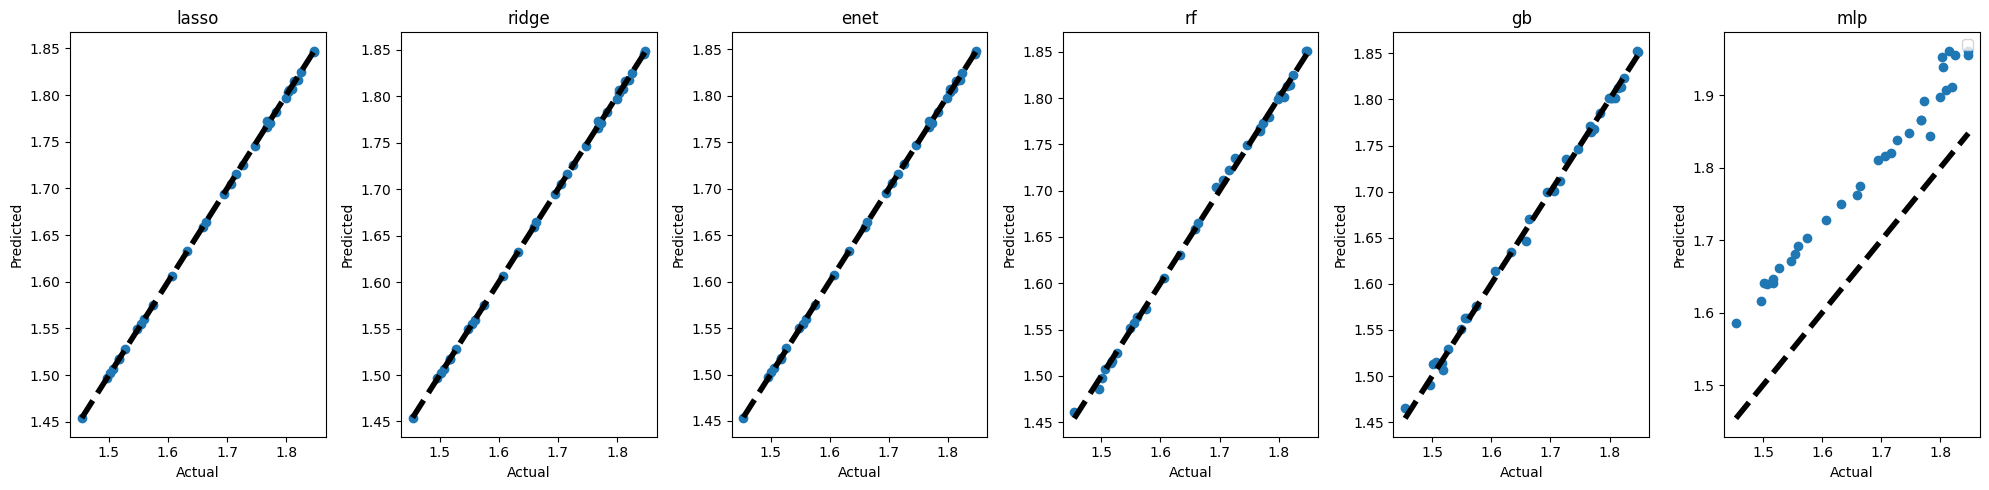

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=len(fitted_models), figsize=(20, 5))

for i, (name, model) in enumerate(fitted_models.items()):
    pred = model.predict(X_test)
    axs[i].scatter(y_test, pred)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    axs[i].set_title(name)
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')

plt.tight_layout()
plt.legend()
plt.show()


From above plots, its clear, we can choose any of linear regression models. 
We went ahead with elastic net

# Actual File

Dataset given to us had multiple cell_id, we have looped to generate predictons for each cell_id 

Best hyperparameters: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.1}
For cell 5
R2: 0.9998381013137483
MAE: 0.0010144702483552046


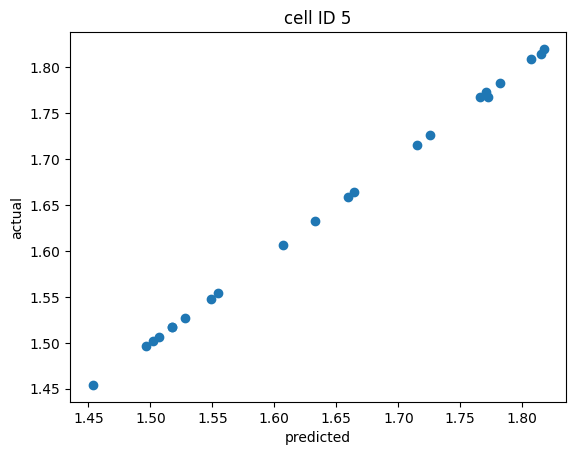

Best hyperparameters: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.9}
For cell 6
R2: 0.9998441886815936
MAE: 0.001367693574791233


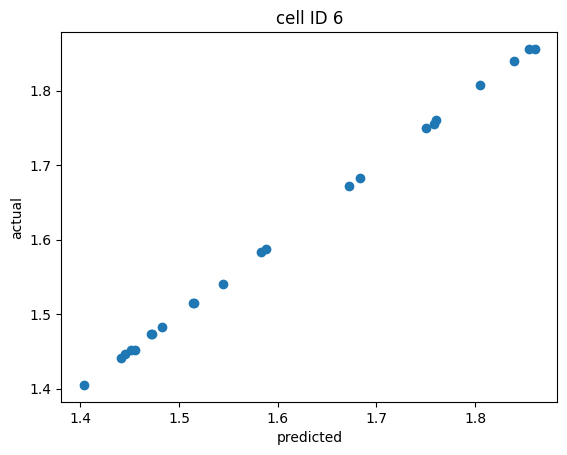

Best hyperparameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}
For cell 7
R2: 0.9996970998826121
MAE: 0.0015764281027925002


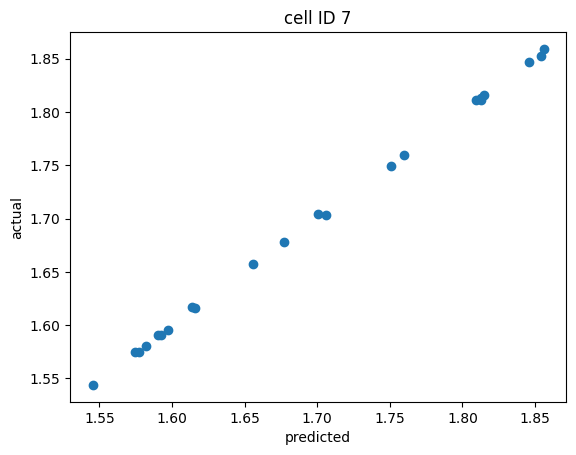

Best hyperparameters: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.9}
For cell 18
R2: 0.999602879630073
MAE: 0.0012464647393312016


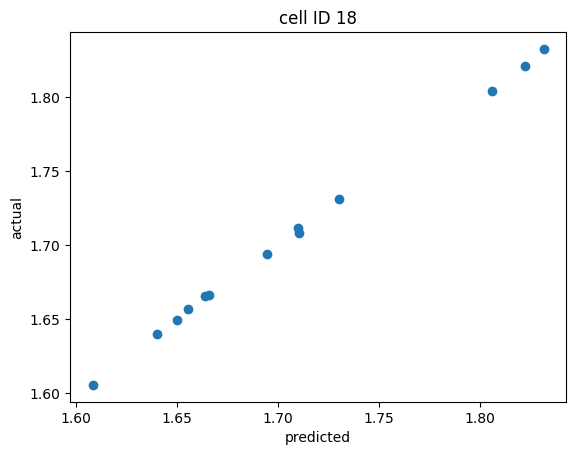

In [20]:
import joblib
models = {}
for i in df_discharge1['cell_id'].unique().tolist():
    #selecting strong feature points for model input
    df_temp=df_discharge1[df_discharge1['cell_id']==i]
    X=df_temp[['cycle_number','time','VT','Vt','V/t']]
    y = df_temp['capacity']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)
    pipeline = make_pipeline(StandardScaler(), ElasticNet(random_state=123))


    hyperparameters = { 
        'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],                        
        'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
    }


    model = GridSearchCV(pipeline, hyperparameters, cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    best_hyperparams = model.best_params_
    print('Best hyperparameters:', best_hyperparams)


    model.fit(X, y)
    models[i] = model
    joblib.dump(model, 'model_'+str(i)+'.pkl')  # Save the trained model as a file


    pred = model.predict(X_test)
    print("For cell "+str(i))
    print('R2:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))

    enet = model.predict(X_test)
    plt.scatter(enet, y_test)
    plt.title('cell ID '+str(i))
    plt.xlabel('predicted')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    plt.ylabel('actual')
    plt.show()
    
    #writing predicted values to an Excel file
    #enet_df=pd.DataFrame(enet,columns=['predicted on test'])
    #print((enet_df))
    #y_test=y_test.reset_index(drop=True)
    #y_test_df=y_test.to_frame(name='Known_capacity_on_test')
    
   # dff=pd.concat([enet_df,y_test_df],axis=1)
    
    #filename='C:/Python/H23/day1/day3/train' +str(i)+'.xlsx'
    
    #dff.to_excel(filename)

# Test dataset

Preparing test dataset in line with train data

In [21]:
#test Dataset
test_df=pd.read_csv(test_data)

test_df.dropna(inplace=True)
test_df=test_df[test_df['current_measured']>-3]
test_df_discharge=test_df[test_df['current_measured']<-0.1]
test_df_discharge["diff"] = test_df_discharge["voltage_measured"] - test_df_discharge["voltage_measured"].shift()
test_df_discharge.dropna()
test_df_discharge= test_df_discharge[test_df_discharge["diff"] < 0]
test_df_discharge1=test_df_discharge.groupby(['cell_id','cycle_number']).last().reset_index()
test_df_discharge1

test_df_discharge1['V/t']=test_df_discharge1['voltage_measured']/test_df_discharge1['time']
test_df_discharge1['Vt']=test_df_discharge1['voltage_measured']*test_df_discharge1['time']
test_df_discharge1['VT']=test_df_discharge1['voltage_measured']*test_df_discharge1['temperature_measured']
test_df_discharge1['V/T']=test_df_discharge1['voltage_measured']/test_df_discharge1['temperature_measured']

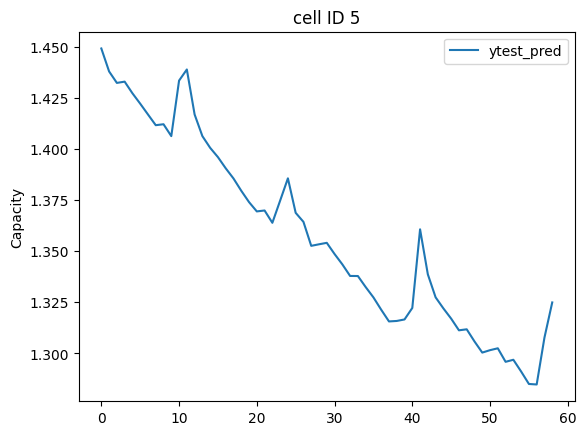

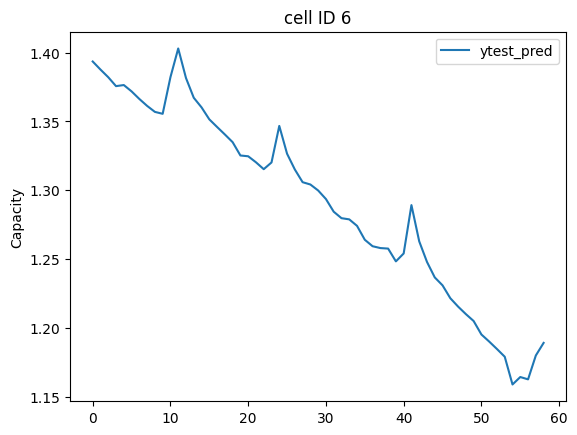

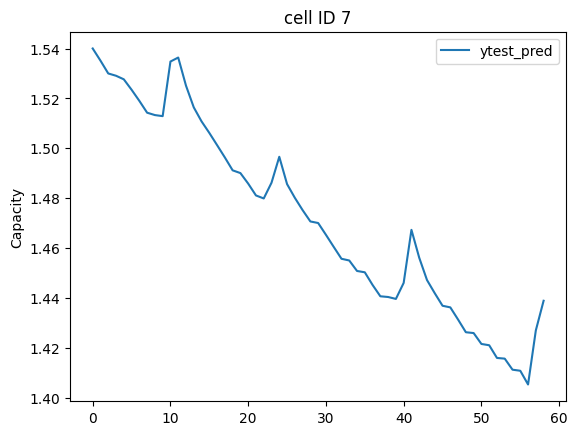

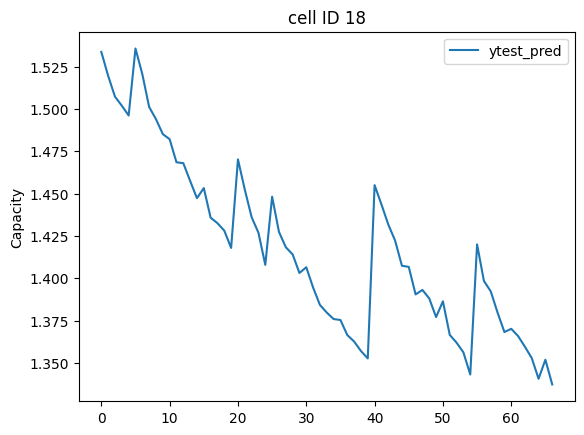

In [22]:
for i in test_df_discharge1['cell_id'].unique().tolist():
    temp_df=test_df_discharge1[test_df_discharge1['cell_id']==i]
    temp_df=temp_df[['cycle_number','time','VT','Vt','V/t']]
    model = joblib.load('model_{}.pkl'.format(i))
    ytest_pred = model.predict(temp_df)
    ytest_pred=pd.DataFrame(ytest_pred,columns=['ytest_pred'])
    ytest_pred.plot()
    plt.title('cell ID '+str(i))
    plt.ylabel('Capacity')
    

    
